In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image
import tensorflow as tf
from numba import cuda

device = cuda.get_current_device()

In [2]:
def generate_set_image_tf(x, y, real_origin, imag_origin, frame_size, num_iter, max_dist):
    ratio = y/x
    real_start = real_origin - (frame_size/2)
    imag_start = imag_origin - (ratio*frame_size/2)
    real_stop = real_origin + (frame_size/2)
    imag_stop = (imag_origin + (ratio*frame_size/2))
    real_step = frame_size/x
    imag_step = frame_size/x
    
    #Initializes the constants that define the frame in the imaginary plane which the set image will be generated for
    
    with tf.device("/GPU:0"): #All tensor math and creation happens on GPU to maximize computational parallelism
        real_arr_1d = tf.range(real_start, real_stop, real_step)
        real_arr_1d = tf.constant(tf.reshape(real_arr_1d, (1,real_arr_1d.shape[0])))
        imag_arr_1d = tf.range(imag_start, imag_stop, imag_step)
        imag_arr_1d = tf.constant(tf.reshape(imag_arr_1d, (1,imag_arr_1d.shape[0])))
        
        
        #Defines the imaginary number map as an input tensor for the main iterative algorithm
        real_tile = tf.constant([1,imag_arr_1d.shape[0]])
        real_arr = tf.tile(real_arr_1d, real_tile)
        
        imag_tile = tf.constant([1,real_arr_1d.shape[0]])
        imag_arr = tf.tile(imag_arr_1d, imag_tile)
        
        point_map = tf.complex(real_arr, tf.transpose(imag_arr))
        
        
        #The following three lines define the main iterative algorithm: z_(n+1) = (z_n * z_n) + c, where z_0 = c
        point_map_orig = tf.raw_ops.Copy(input=point_map) #z_0 = c
        for i in range(num_iter):
            point_map = tf.math.accumulate_n([tf.math.multiply(point_map, point_map),point_map_orig]) #z_(n+1) = (z_n * z_n) + c
            
        
        
        #Defines the set array as a tensor of the same size as the point map, with 1 where |point map| <= maximum distance, 
        #and 0 elsewhere. This is the primary charactaristic that determines whether a point in imaginary space is inside or
        #outside of the Mandelbrot set
        abs_arr = tf.math.abs(point_map)
        
        zeros = tf.zeros((point_map.shape[0], point_map.shape[1]))
        ones = tf.ones((point_map.shape[0], point_map.shape[1]))
        
        set_arr = tf.where(abs_arr <= max_dist, ones, zeros)
        
        
        return set_arr.numpy()

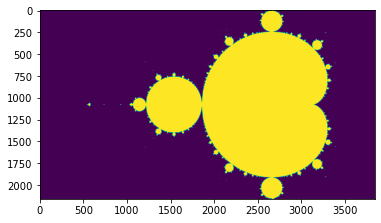

In [3]:
width = 3840
height = 2160
real_origin = -.7
imag_origin = 0
frame_size = 3
num_iter = 1000
max_dist = 4

set_arr = generate_set_image_tf(width, height, real_origin, imag_origin, frame_size, num_iter, max_dist)
plt.imshow(set_arr)


In [4]:
def generate_set_image_color_tf(x, y, real_origin, imag_origin, frame_size, num_iter, max_dist, colors):
    ratio = y/x
    real_start = real_origin - (frame_size/2)
    imag_start = imag_origin - (ratio*frame_size/2)
    real_stop = real_origin + (frame_size/2)
    imag_stop = (imag_origin + (ratio*frame_size/2))
    real_step = frame_size/x
    imag_step = frame_size/x
    
    with tf.device("/GPU:0"):
        real_arr_1d = tf.range(real_start, real_stop, real_step)
        real_arr_1d = tf.constant(tf.reshape(real_arr_1d, (1,real_arr_1d.shape[0])))
        imag_arr_1d = tf.range(imag_start, imag_stop, imag_step)
        imag_arr_1d = tf.constant(tf.reshape(imag_arr_1d, (1,imag_arr_1d.shape[0])))
        
        real_tile = tf.constant([1,imag_arr_1d.shape[0]])
        real_arr = tf.tile(real_arr_1d, real_tile)
        
        imag_tile = tf.constant([1,real_arr_1d.shape[0]])
        imag_arr = tf.tile(imag_arr_1d, imag_tile)
        
    
        point_map = tf.complex(real_arr, tf.transpose(imag_arr))
        
        point_map_orig = tf.raw_ops.Copy(input=point_map)
        for i in range(num_iter):
            point_map = tf.math.accumulate_n([tf.math.multiply(point_map, point_map),point_map_orig])
        
        
        
        abs_arr = tf.math.abs(point_map)
        abs_arr = tf.reshape(abs_arr, (abs_arr.shape[0], abs_arr.shape[1],1))
        tile = tf.constant([1,1,3])
        abs_arr = tf.tile(abs_arr, tile)
        
        background = colors.pop()
        set_arr = tf.constant([[background]*point_map.shape[1]]*point_map.shape[0], dtype=tf.float32)
        color_cutoffs = []
        color_tensors = []
        for j,color in enumerate(colors):
            color_cutoffs.append(int(max_dist*((j+1)/len(colors))))
            color_tensors.append(tf.constant([[color]*point_map.shape[1]]*point_map.shape[0]))
        for k in range(len(colors)-1,0, -1):
            set_arr = tf.where(abs_arr <= color_cutoffs[k], color_tensors[k], set_arr)
            
        
        
        return set_arr.numpy()

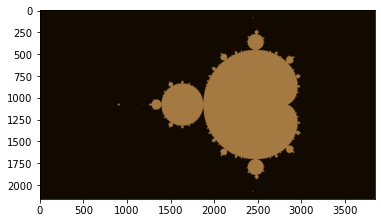

In [5]:
frame1 = (-.7,0,4)
frame2 = (-.705, .246,  0.005)



width = 3840
height = 2160
real_origin, imag_origin, frame_size = frame1
num_iter = 1100
max_dist = 30

colors = [
    [0.,0.,0.],
    [165.,122.,66.],
    [18.,9.,0.]
    
]




set_arr = generate_set_image_color_tf(width, height, real_origin, imag_origin, frame_size, num_iter, max_dist, colors)
plt.imshow(set_arr/255)